In [1]:
## Imports and such
import sys
sys.path.append('../')

from ibmfl_cli_automator.run import get_config, Runner, changedict

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

fusion_algos = [a for a in os.listdir("../../testtest/remote") if a.find(".") == -1]

In [4]:
fusion_algos

['shuf_iter_avg', 'fed_avg', 'coord_med', 'krum', 'iter_avg']

In [5]:
results = {}
n_trials = 1

In [61]:
import pandas as pd
import numpy as np

def av(item):
    arr = np.array(item)
    avg = arr.mean(axis=0).flatten()
    return avg

def process_trial_results(results):
    """
    averages the two numbers per round/metric, then takes the avg and std
    of each round/metric across the trials
    """
    dfs = []
    for i in range(n_trials):
        rounds = results[i]['metadata'][0]['round_no']
        dfs.append(pd.DataFrame(
            {key: av(item) for key, item in results[i].items()
            if key is not "metadata"},
            index=rounds
        ))

    return {
        "avg": pd.DataFrame(
            np.array(dfs).mean(axis=0), index=dfs[0].index, columns=dfs[0].columns
        ),
        "std": pd.DataFrame(
            np.array(dfs).std(axis=0), index=dfs[0].index, columns=dfs[0].columns
        )
    }


def process_better_trial_results(dfs):
    """
    averages the two numbers per round/metric, then takes the avg and std
    of each round/metric across the trials
    """
    return {
        "avg": pd.DataFrame(
            np.array(dfs).mean(axis=0), index=dfs[0].index, columns=dfs[0].columns
        ),
        "std": pd.DataFrame(
            np.array(dfs).std(axis=0), index=dfs[0].index, columns=dfs[0].columns
        )
    }

import json


def postproc_fn(staging, folder=None):
    if folder is None:
        folder = f"{staging}/latest/trial1"
    parties = {}
    for obj in os.listdir(folder):
        if obj.endswith(".json"):
            party = int(obj[:-5].split("party")[1])
            dfs = []
            with open(f"{folder}/{obj}", 'r') as openfile:
                json_object = json.load(openfile)
                for round in json_object:
                    round_no = round['round_no']
                    dfs.append(pd.DataFrame(round).iloc[:, 1:3])
                    dfs[round_no] = dfs[round_no].append(
                        pd.Series(
                            dfs[round_no].iloc[0] - dfs[0].iloc[0],
                            name="te"
                        )
                    )
                    dfs[round_no] = pd.Series(
                        dfs[round_no].iloc[:, 0].tolist() + \
                        dfs[round_no].iloc[:, 0].tolist(),
                        index=("pre_train:" + dfs[round_no].index).tolist() + \
                        ("post_train:" + dfs[round_no].index).tolist(),
                        name=round_no
                    )
                parties[party] = pd.DataFrame(dfs)

    round_results = np.array(list(parties.values())).mean(axis=0)
    round_stds = np.array(list(parties.values())).std(axis=0)
    round_avgs = pd.DataFrame(
        round_results,
        index=parties[list(parties.keys())[0]].index,
        columns=parties[list(parties.keys())[0]].columns
    )
    round_stds = pd.DataFrame(
        round_stds,
        index=parties[list(parties.keys())[0]].index,
        columns=parties[list(parties.keys())[0]].columns
    )
    round_avgs.axes[0].name = "round"

    return round_avgs, round_stds

In [70]:
nresults = {fusion: {} for fusion in fusion_algos}

for fusion in fusion_algos:
    fresults = postproc_fn(f"../../", folder=f"../../{fusion}/trial1/")
    nresults[fusion]['avg'] = fresults[0]
    nresults[fusion]['std'] = fresults[1]

{86:     pre_train:ts  pre_train:eval:loss  pre_train:eval:acc  \
0   1.682524e+09                  NaN                 NaN   
1   1.682524e+09             0.710413            0.792793   
2   1.682524e+09             0.529948            0.855856   
3   1.682524e+09             0.462898            0.882883   
4   1.682524e+09             0.419236            0.900901   
5   1.682524e+09             0.382070            0.918919   
6   1.682524e+09             0.359656            0.918919   
7   1.682524e+09             0.331700            0.936937   
8   1.682524e+09             0.310323            0.936937   
9   1.682524e+09             0.287010            0.936937   
10  1.682524e+09             0.269448            0.936937   
11  1.682524e+09             0.253740            0.936937   
12  1.682524e+09             0.241698            0.936937   
13  1.682524e+09             0.233211            0.936937   
14  1.682524e+09             0.220714            0.936937   
15  1.682524e+09   

{69:     pre_train:ts  pre_train:eval:loss  pre_train:eval:acc  \
0   1.682535e+09                  NaN                 NaN   
1   1.682535e+09             0.620468            0.855856   
2   1.682536e+09             0.276456            0.918919   
3   1.682536e+09             0.209334            0.927928   
4   1.682536e+09             0.169011            0.927928   
5   1.682536e+09             0.147876            0.936937   
6   1.682536e+09             0.132880            0.954955   
7   1.682536e+09             0.122380            0.954955   
8   1.682536e+09             0.115946            0.963964   
9   1.682536e+09             0.107781            0.963964   
10  1.682536e+09             0.106786            0.963964   
11  1.682536e+09             0.101517            0.963964   
12  1.682536e+09             0.095991            0.972973   
13  1.682536e+09             0.095860            0.972973   
14  1.682536e+09             0.094966            0.972973   
15  1.682536e+09   

{86:     pre_train:ts  pre_train:eval:loss  pre_train:eval:acc  \
0   1.682538e+09                  NaN                 NaN   
1   1.682538e+09             0.765189            0.774775   
2   1.682538e+09             0.535480            0.855856   
3   1.682538e+09             0.472729            0.864865   
4   1.682538e+09             0.435456            0.891892   
5   1.682538e+09             0.400885            0.891892   
6   1.682538e+09             0.357367            0.918919   
7   1.682538e+09             0.338359            0.927928   
8   1.682538e+09             0.318208            0.927928   
9   1.682538e+09             0.290405            0.936937   
10  1.682538e+09             0.279311            0.936937   
11  1.682538e+09             0.260699            0.936937   
12  1.682538e+09             0.251279            0.936937   
13  1.682538e+09             0.232855            0.936937   
14  1.682538e+09             0.222840            0.936937   
15  1.682538e+09   

{86:     pre_train:ts  pre_train:eval:loss  pre_train:eval:acc  \
0   1.682539e+09                  NaN                 NaN   
1   1.682540e+09             0.966839            0.720721   
2   1.682540e+09             0.993540            0.774775   
3   1.682540e+09             0.932490            0.783784   
4   1.682540e+09             1.006111            0.801802   
5   1.682540e+09             1.191162            0.783784   
6   1.682540e+09             1.188631            0.783784   
7   1.682540e+09             1.085672            0.801802   
8   1.682540e+09             1.306624            0.774775   
9   1.682540e+09             1.461558            0.774775   
10  1.682540e+09             1.414851            0.756757   
11  1.682540e+09             1.331838            0.801802   
12  1.682540e+09             1.406526            0.783784   
13  1.682540e+09             1.527773            0.765766   
14  1.682540e+09             1.538167            0.783784   
15  1.682540e+09   

{86:     pre_train:ts  pre_train:eval:loss  pre_train:eval:acc  \
0   1.682541e+09                  NaN                 NaN   
1   1.682541e+09             0.692719            0.801802   
2   1.682541e+09             0.520636            0.855856   
3   1.682541e+09             0.464855            0.873874   
4   1.682541e+09             0.423391            0.900901   
5   1.682541e+09             0.392098            0.918919   
6   1.682541e+09             0.356363            0.927928   
7   1.682542e+09             0.329815            0.927928   
8   1.682542e+09             0.307737            0.936937   
9   1.682542e+09             0.286080            0.936937   
10  1.682542e+09             0.274683            0.936937   
11  1.682542e+09             0.257976            0.936937   
12  1.682542e+09             0.241737            0.936937   
13  1.682542e+09             0.236120            0.936937   
14  1.682542e+09             0.223942            0.936937   
15  1.682542e+09   

In [71]:
nresults

{'shuf_iter_avg': {'avg':        pre_train:ts  pre_train:eval:loss  pre_train:eval:acc  \
  round                                                          
  0      1.682524e+09                  NaN                 NaN   
  1      1.682524e+09             0.576097            0.860360   
  2      1.682524e+09             0.320745            0.910110   
  3      1.682524e+09             0.257250            0.927828   
  4      1.682524e+09             0.221883            0.939039   
  5      1.682524e+09             0.198313            0.947347   
  6      1.682524e+09             0.181703            0.951752   
  7      1.682524e+09             0.167421            0.955455   
  8      1.682524e+09             0.156271            0.958058   
  9      1.682524e+09             0.147452            0.960160   
  10     1.682524e+09             0.139872            0.961261   
  11     1.682524e+09             0.133970            0.962863   
  12     1.682524e+09             0.128302          

In [30]:
for fusion in fusion_algos[4:]:
    display("testing fusion algorithm:")
    display(fusion)
    agg, party, glob = get_config(f"../../testtest/unbalanced_data/remote3/{fusion}/")
    display(glob)
    display(agg)

    results[fusion] = []
    machines = glob['machines']
    experiments = glob['experiments']
    agg['hyperparams']['global']['termination_accuracy'] = 0.9999
    agg['hyperparams']['global']['max_timeout'] = 50
#     party['data']['info']['npz_file'] = '${staging_dir}/testtest/balanced_data/data_party${id}.npz'
#     agg['hyperparams']['global']['rounds'] = 2
    experiments[0]['n_parties'] = 90

    for i in range(n_trials):
        runner = Runner()
        experiments[0]
        runner.run_experiment(
            experiments[0],
            machines,
            agg,
            party,
            ui_mode="cli"
        )
        break
    break
#         runner.call_postproc_fn()
#         results[fusion].append(postproc_fn(f"../../"))

    results[fusion] = process_better_trial_results(results[fusion])
    results[fusion]['avg'].to_csv(f"../../testtest/unbalanced_data/remote3/{fusion}/results_avg.csv")
    results[fusion]['std'].to_csv(f"../../testtest/unbalanced_data/remote3/{fusion}/results_std.csv")
    display(results[fusion]['avg'])

'testing fusion algorithm:'

'iter_avg'

{'experiments': [{'agg_machine': 'local0',
   'isLocalRun': False,
   'local_ibmfl_dir': '/home/trevormaxjs/Documents/Engineering/Research/ibmfl',
   'local_staging_dir': '/home/trevormaxjs/Documents/Engineering/Research',
   'n_parties': 90,
   'n_rounds': 20,
   'n_trials': 1,
   'party_machines': ['popdesk0',
    'popdesk1',
    'popdesk2',
    'popdesk3',
    'popdesk4',
    'popdesk5',
    'popdesk6',
    'popdesk7',
    'popdesk8',
    'popdesk9',
    'worktop10',
    'worktop11',
    'worktop12',
    'worktop13',
    'worktop14',
    'worktop15',
    'worktop16',
    'worktop17',
    'worktop18',
    'worktop19',
    'worktop20',
    'worktop21',
    'worktop22',
    'worktop23',
    'worktop24',
    'worktop25',
    'worktop26',
    'worktop27',
    'worktop28',
    'worktop29',
    'worktop30',
    'worktop31',
    'worktop32',
    'worktop33',
    'worktop34',
    'worktop35',
    'worktop36',
    'worktop37',
    'worktop38',
    'worktop39',
    'worktop40',
    'worktop41'

{'connection': {'info': {'ip': '${agg_ip}',
   'port': '${agg_port}',
   'tls_config': {'enable': False}},
  'name': 'FlaskConnection',
  'path': 'ibmfl.connection.flask_connection',
  'sync': False},
 'data': {'info': {'npz_file': '${ibmfl_dir}/examples/datasets/mnist.npz'},
  'name': 'MnistKerasDataHandler',
  'path': 'ibmfl.util.data_handlers.mnist_keras_data_handler'},
 'fusion': {'name': 'IterAvgFusionHandler',
  'path': 'ibmfl.aggregator.fusion.iter_avg_fusion_handler'},
 'hyperparams': {'global': {'max_timeout': 60,
   'num_parties': '${n_parties}',
   'perc_quorum': 0.5,
   'rounds': '${n_rounds}',
   'termination_accuracy': 0.9},
  'local': {'optimizer': {'lr': 0.01}, 'training': {'epochs': 10}}},
 'protocol_handler': {'name': 'ProtoHandler',
  'path': 'ibmfl.aggregator.protohandler.proto_handler'}}

Starting trial 1/1 at 2023-04-26 20:25:40:
Trial has ID 20230426T202540
192.168.1.176 22 trevormaxjs
Agg connection made to 192.168.1.176
Started agg...
192.168.1.154 22 trevormaxjs
Party 0 connection made to 192.168.1.154
Started party 0...
192.168.1.154 22 trevormaxjs
Party 1 connection made to 192.168.1.154
Started party 1...
192.168.1.154 22 trevormaxjs
Party 2 connection made to 192.168.1.154
Started party 2...
192.168.1.154 22 trevormaxjs
Party 3 connection made to 192.168.1.154
Started party 3...
192.168.1.154 22 trevormaxjs
Party 4 connection made to 192.168.1.154
Started party 4...
192.168.1.154 22 trevormaxjs
Party 5 connection made to 192.168.1.154
Started party 5...
192.168.1.154 22 trevormaxjs
Party 6 connection made to 192.168.1.154
Started party 6...
192.168.1.154 22 trevormaxjs
Party 7 connection made to 192.168.1.154
Started party 7...
192.168.1.154 22 trevormaxjs
Party 8 connection made to 192.168.1.154
Started party 8...
192.168.1.154 22 trevormaxjs
Party 9 connectio

Round progress:   0%|          | 0/20 [00:00<?, ?it/s]

Party responses:   0%|          | 0/45 [00:00<?, ?it/s]

Done training at 2023-04-26 16:52:15!
Agg finished: yes & Parties finished: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]


FileNotFoundError: [Errno 2] No such file

In [16]:
# import paramiko
# server_in, port_in, username_in = "192.168.1.154 22 trevormaxjs".split(" ")
# client = paramiko.SSHClient()
# client.load_system_host_keys()
# client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
# print(server_in, port_in, username_in)
# client.connect(server_in, port=port_in, username=username_in) #, key_filename="/home/trevormaxjs/.ssh/poptower")

192.168.1.154 22 trevormaxjs


AuthenticationException: Authentication failed.

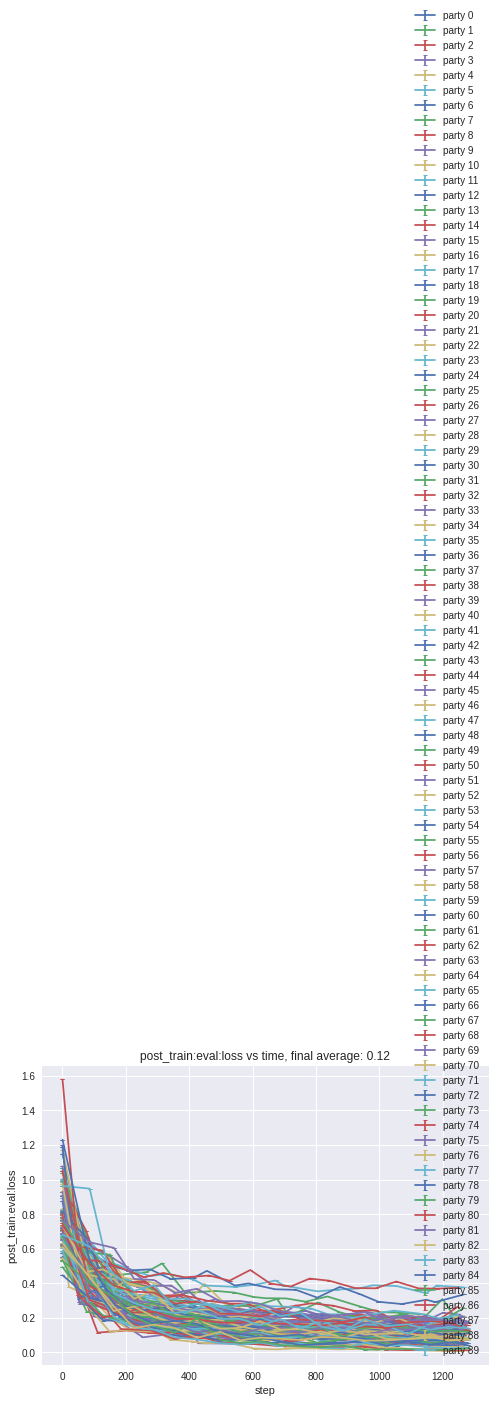

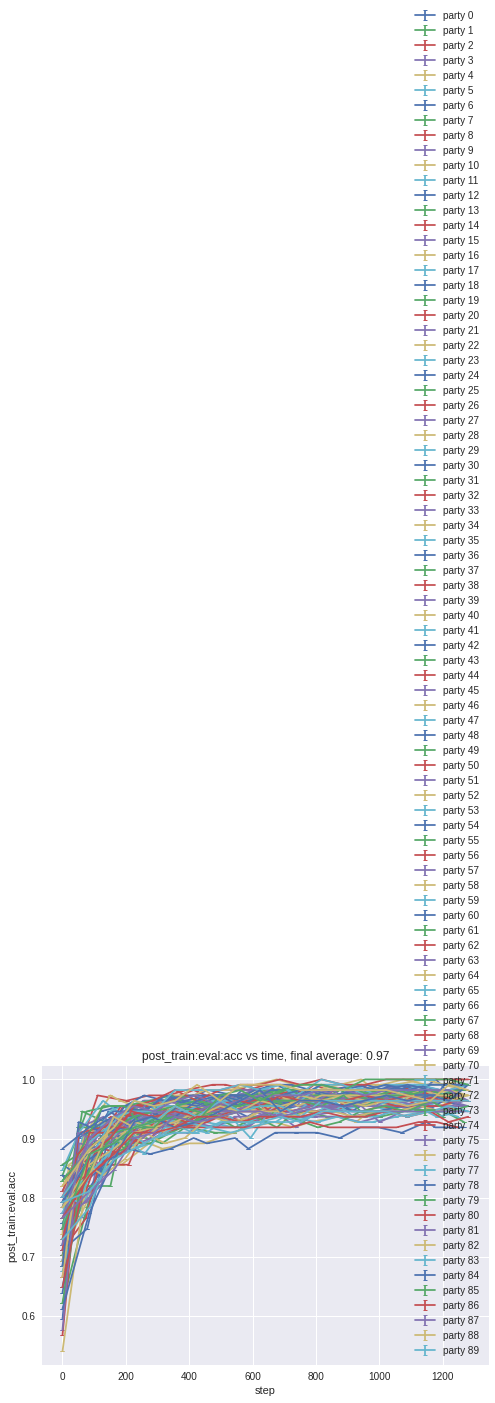

In [32]:
runner.call_postproc_fn()

In [31]:
# runner.call_postproc_fn()

results[fusion].append(postproc_fn("../../"))

results[fusion] = process_better_trial_results(results[fusion])
results[fusion]['avg'].to_csv(f"../../testtest/unbalanced_data/remote3/{fusion}/results_avg.csv")
results[fusion]['std'].to_csv(f"../../testtest/unbalanced_data/remote3/{fusion}/results_std.csv")
display(results[fusion]['avg'])

{86:     pre_train:ts  pre_train:eval:loss  pre_train:eval:acc  \
0   1.682541e+09                  NaN                 NaN   
1   1.682541e+09             0.692719            0.801802   
2   1.682541e+09             0.520636            0.855856   
3   1.682541e+09             0.464855            0.873874   
4   1.682541e+09             0.423391            0.900901   
5   1.682541e+09             0.392098            0.918919   
6   1.682541e+09             0.356363            0.927928   
7   1.682542e+09             0.329815            0.927928   
8   1.682542e+09             0.307737            0.936937   
9   1.682542e+09             0.286080            0.936937   
10  1.682542e+09             0.274683            0.936937   
11  1.682542e+09             0.257976            0.936937   
12  1.682542e+09             0.241737            0.936937   
13  1.682542e+09             0.236120            0.936937   
14  1.682542e+09             0.223942            0.936937   
15  1.682542e+09   

pre_train:ts  pre_train:eval:loss  pre_train:eval:acc  \
round                                                          
0      1.682541e+09                  NaN                 NaN   
1      1.682541e+09             0.563169            0.864865   
2      1.682541e+09             0.320155            0.909810   
3      1.682541e+09             0.256314            0.929129   
4      1.682541e+09             0.222657            0.941041   
5      1.682541e+09             0.199969            0.947247   
6      1.682541e+09             0.181281            0.952152   
7      1.682542e+09             0.166688            0.955556   
8      1.682542e+09             0.156763            0.957958   
9      1.682542e+09             0.148061            0.959760   
10     1.682542e+09             0.141077            0.961161   
11     1.682542e+09             0.134678            0.962663   
12     1.682542e+09             0.128995            0.964965   
13     1.682542e+09             0.124798            0.966166   
14     1.682542e+09             0.120727            0.967668   
15     1.682542e+09             0.116426            0.969269   
16     1.682542e+09             0.114296            0.969870   
17     1.682542e+09             0.111383            0.970370   
18     1.682542e+09             0.109154            0.970971   
19     1.682542e+09             0.108113            0.971872   

       pre_train:eval:f1 micro  pre_train:eval:precision micro  \
round                                                            
0                          NaN                             NaN   
1                     0.832222                        0.955778   
2                     0.909444                        0.934778   
3                     0.929778                        0.941556   
4                     0.941222                        0.949222   
5                     0.947889                        0.953444   
6                     0.952889                        0.957111   
7                     0.955333                        0.958778   
8                     0.957000                        0.960000   
9                     0.958778                        0.960889   
10                    0.960333                        0.962333   
11                    0.962778                        0.964444   
12                    0.963889                        0.965667   
13                    0.965444                        0.966889   
14                    0.966111                        0.967556   
15                    0.967889                        0.968556   
16                    0.968444                        0.969222   
17                    0.969778                        0.970667   
18                    0.970444                        0.971222   
19                    0.971111                        0.972000   

       pre_train:eval:recall micro  pre_train:eval:f1 macro  \
round                                                         
0                              NaN                      NaN   
1                         0.737222                 0.802333   
2                         0.884222                 0.884333   
3                         0.919222                 0.908444   
4                         0.933667                 0.923222   
5                         0.942111                 0.931000   
6                         0.947889                 0.935333   
7                         0.951333                 0.939111   
8                         0.953444                 0.940778   
9                         0.955889                 0.943444   
10                        0.956556                 0.944667   
11                        0.959000                 0.947556   
12                        0.960667                 0.949556   
13                        0.962111                 0.951000   
14                        0.963778                 0.952333   
15                        0.966000                 0.954556   
16         

In [34]:
results = {fusion: {} for fusion in fusion_algos}

In [16]:
results['iter_avg']['avg'].columns

Index(['pre_train:ts', 'pre_train:eval:loss', 'pre_train:eval:acc',
       'pre_train:eval:f1 micro', 'pre_train:eval:precision micro',
       'pre_train:eval:recall micro', 'pre_train:eval:f1 macro',
       'pre_train:eval:precision macro', 'pre_train:eval:recall macro',
       'pre_train:eval:f1 weighted', 'pre_train:eval:precision weighted',
       'pre_train:eval:recall weighted', 'pre_train:te', 'post_train:ts',
       'post_train:eval:loss', 'post_train:eval:acc',
       'post_train:eval:f1 micro', 'post_train:eval:precision micro',
       'post_train:eval:recall micro', 'post_train:eval:f1 macro',
       'post_train:eval:precision macro', 'post_train:eval:recall macro',
       'post_train:eval:f1 weighted', 'post_train:eval:precision weighted',
       'post_train:eval:recall weighted', 'post_train:te'],
      dtype='object')

### GET FED AVG WORKING!!

In [36]:
for fusion in fusion_algos:
    results[fusion] = {}
    results[fusion]['avg'] = pd.read_csv(f"../../testtest/unbalanced_data/remote3/{fusion}/results_avg.csv", index_col=0)
    results[fusion]['std'] = pd.read_csv(f"../../testtest/unbalanced_data/remote3/{fusion}/results_std.csv", index_col=0)
    results[fusion]['avg']['train_time'] = results[fusion]['avg']['post_train:ts'] - results[fusion]['avg']['pre_train:ts'][0]
    results[fusion]['std']['train_time'] = results[fusion]['std']['post_train:ts'] - results[fusion]['std']['pre_train:ts'][0]
results

{'shuf_iter_avg': {'avg':        pre_train:ts  pre_train:eval:loss  pre_train:eval:acc  \
  round                                                          
  0      1.682524e+09                  NaN                 NaN   
  1      1.682524e+09             0.576097            0.860360   
  2      1.682524e+09             0.320745            0.910110   
  3      1.682524e+09             0.257250            0.927828   
  4      1.682524e+09             0.221883            0.939039   
  5      1.682524e+09             0.198313            0.947347   
  6      1.682524e+09             0.181703            0.951752   
  7      1.682524e+09             0.167421            0.955455   
  8      1.682524e+09             0.156271            0.958058   
  9      1.682524e+09             0.147452            0.960160   
  10     1.682524e+09             0.139872            0.961261   
  11     1.682524e+09             0.133970            0.962863   
  12     1.682524e+09             0.128302          

In [75]:
for fusion in fusion_algos:
    results[fusion]['avg']['train_time'] = results[fusion]['avg']['post_train:ts'] - results[fusion]['avg']['pre_train:ts'][0]
    results[fusion]['std']['train_time'] = results[fusion]['std']['post_train:ts'] - results[fusion]['std']['pre_train:ts'][0]


In [37]:
import matplotlib.pyplot as plt

In [102]:
def plot_results(dict, round, metric):
    plt.figure()
    plt.title(f"{metric} per fusion algorithm at round {round}")
    for i, fusion in enumerate(dict.keys()):
        if dict[fusion]['avg'].shape[0] > 1 or round == 1:
            if round == -1:
                label = f"round {dict[fusion]['avg'].index[-1]}"
            else:
                label = ""
            plt.errorbar(
                [i],
                [dict[fusion]['avg'].iloc[round-1][metric]],
                [dict[fusion]['std'].iloc[round-1][metric]],
                marker='s', mfc='red', label=label
            )
    plt.xticks(np.arange(len(dict.keys())), dict.keys())
    plt.ylabel(metric)
    if round == -1:
        plt.legend()
    plt.show()

    
def plot_results2(dict, metric, xmetric='train_time'):
    """
    """
    plt.figure()
    plt.title(f"{metric} per fusion algorithm vs {xmetric}")
    for i, fusion in enumerate(dict.keys()):
        if dict[fusion]['avg'].shape[0] > 1 or round == 1:
            plt.errorbar(
                dict[fusion]['avg'][xmetric] if not xmetric is "round" else dict[fusion]['avg'].index,
                dict[fusion]['avg'][metric],
                dict[fusion]['std'][metric],
#                 marker='s', mfc='red',
                label=fusion
            )
#     plt.xticks(np.arange(6), dict.keys())
    plt.ylabel(metric)
    plt.xlabel(xmetric)
    plt.legend()
    plt.show()


def earlystop_results(results, metric, cutoff):
    resultscopy = {}
    for i, fusion in enumerate(results.keys()):
        resultscopy[fusion] = {}
        resultscopy[fusion]['avg'] = results[fusion]['avg'].loc[
            results[fusion]['avg'][metric] <= cutoff].copy()
        resultscopy[fusion]['std'] = results[fusion]['std'].loc[
            resultscopy[fusion]['avg'].index].copy()
    return resultscopy

In [39]:
earlystop_results(results, "post_train:eval:acc", 0.9)

{'shuf_iter_avg': {'avg':        pre_train:ts  pre_train:eval:loss  pre_train:eval:acc  \
  round                                                          
  1      1.682524e+09             0.576097             0.86036   
  
         pre_train:eval:f1 micro  pre_train:eval:precision micro  \
  round                                                            
  1                     0.825778                        0.953333   
  
         pre_train:eval:recall micro  pre_train:eval:f1 macro  \
  round                                                         
  1                         0.729111                 0.794333   
  
         pre_train:eval:precision macro  pre_train:eval:recall macro  \
  round                                                                
  1                            0.938444                     0.716556   
  
         pre_train:eval:f1 weighted  ...  post_train:eval:precision micro  \
  round                              ...                                  

flf1 weighted - 

In [73]:
results = nresults

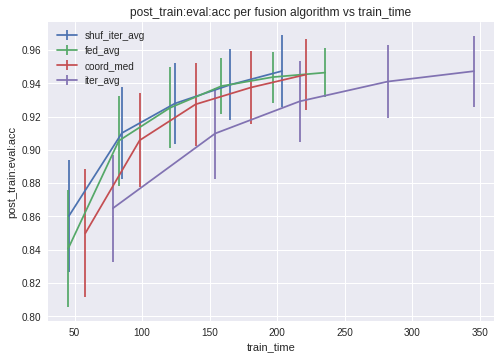

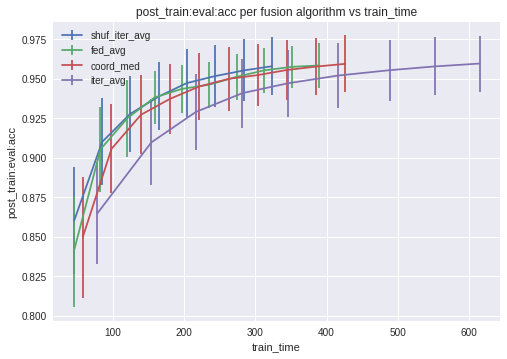

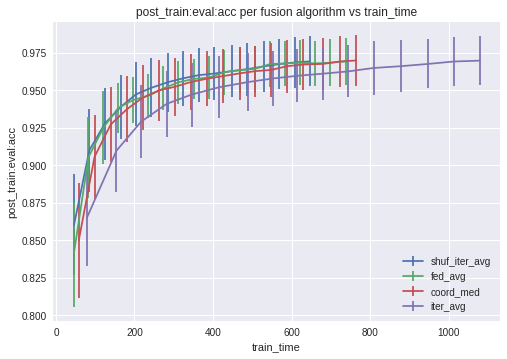

In [103]:
plot_results2(earlystop_results(results, "post_train:eval:acc", 0.95), "post_train:eval:acc")

plot_results2(earlystop_results(results, "post_train:eval:acc", 0.96), "post_train:eval:acc")

plot_results2(earlystop_results(results, "post_train:eval:acc", 0.97), "post_train:eval:acc")

In [105]:
results['krum'] = krum

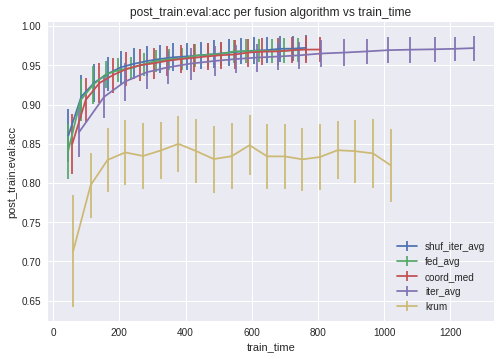

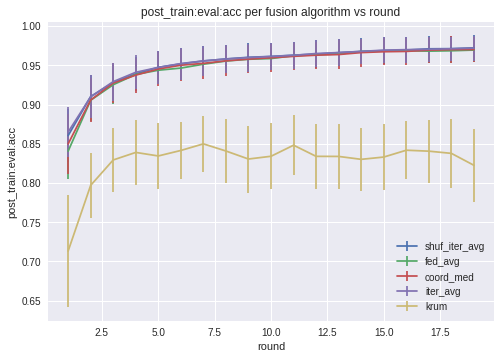

In [106]:
# plot_results2(results, "train_time")
plot_results2(results, "post_train:eval:acc")

plot_results2(results, "post_train:eval:acc", "round")


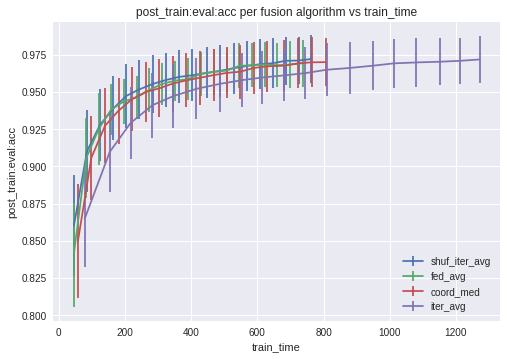

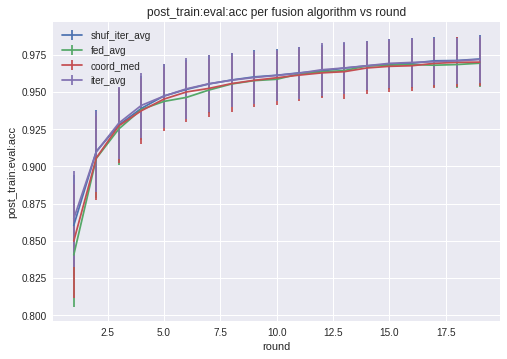

In [115]:
# plot_results2(results, "train_time")
plot_results2(results, "post_train:eval:acc")

plot_results2(results, "post_train:eval:acc", "round")


In [109]:
krum = results.pop('krum')

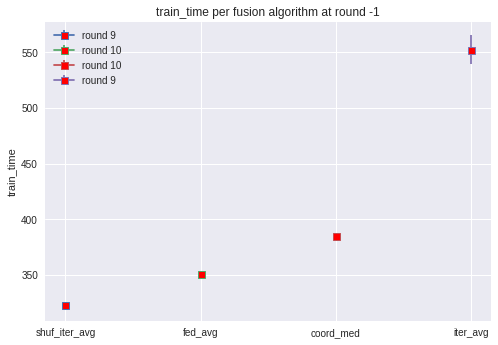

In [114]:
plot_results(
    earlystop_results(results, "post_train:eval:acc", 0.961),
    -1,
    "train_time"
)

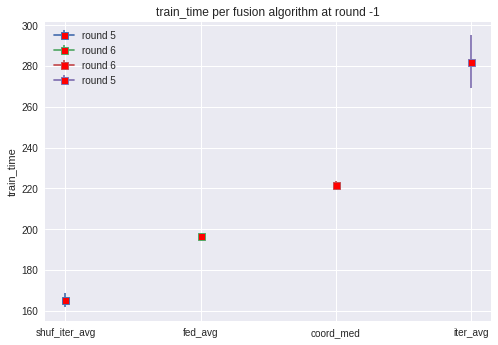

In [117]:
plot_results(earlystop_results(results, "post_train:eval:acc", 0.951), -1, "train_time")

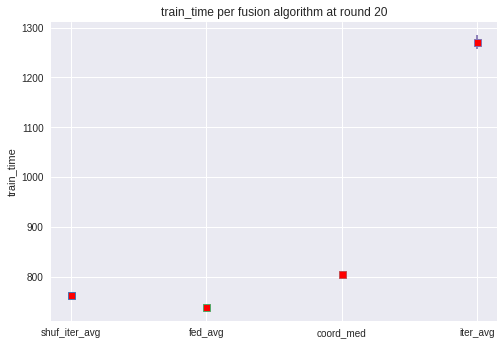

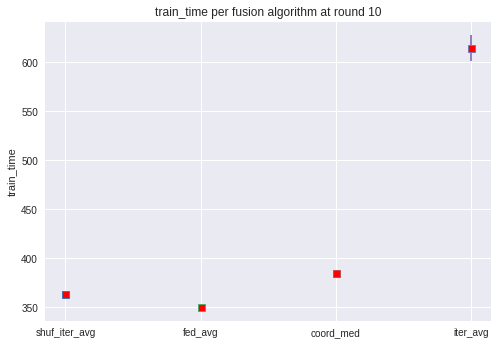

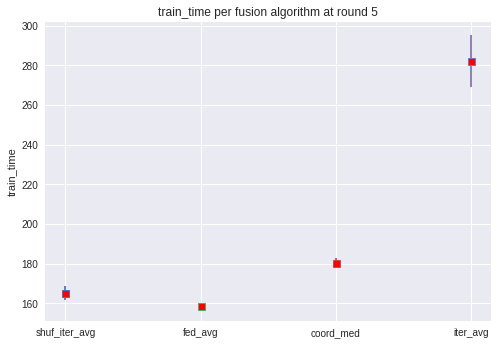

In [98]:
plot_results(results, 20, "train_time")

plot_results(results, 10, "train_time")

plot_results(results, 5, "train_time")

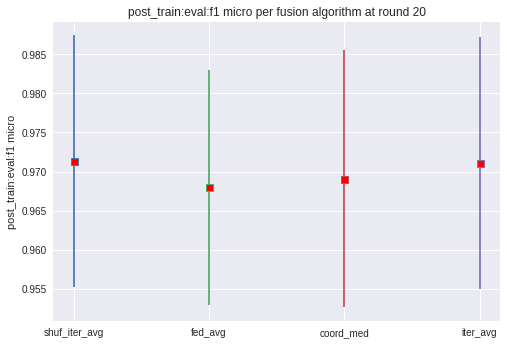

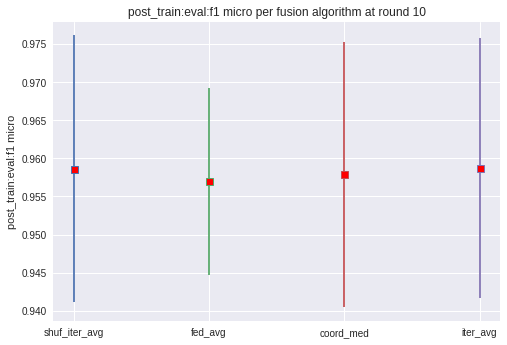

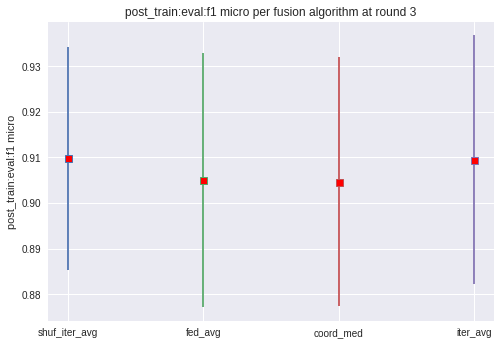

In [118]:
plot_results(results, 20, "post_train:eval:f1 micro")

plot_results(results, 10, "post_train:eval:f1 micro")

plot_results(results, 3, "post_train:eval:f1 micro")

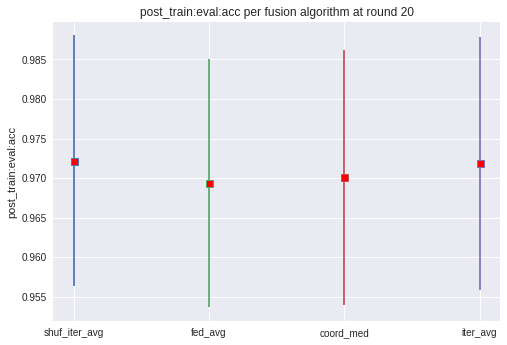

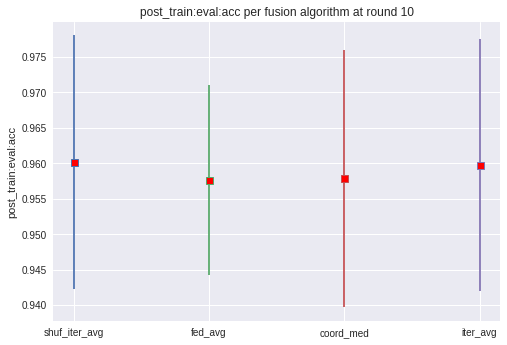

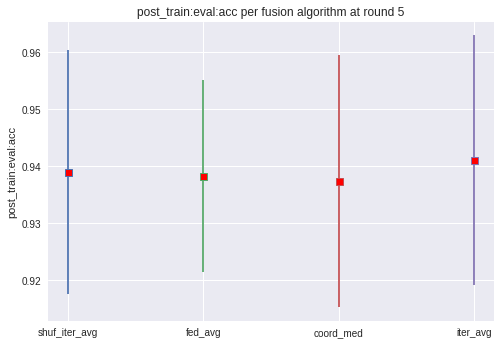

In [100]:
plot_results(results, 20, "post_train:eval:acc")

plot_results(results, 10, "post_train:eval:acc")

plot_results(results, 5, "post_train:eval:acc")

round number vs metric, plot all 6 curves

Usually add rounds but few epochs per round, start with 3 rounds. Find optimal number of rounds and use that as a baseline for further tests.

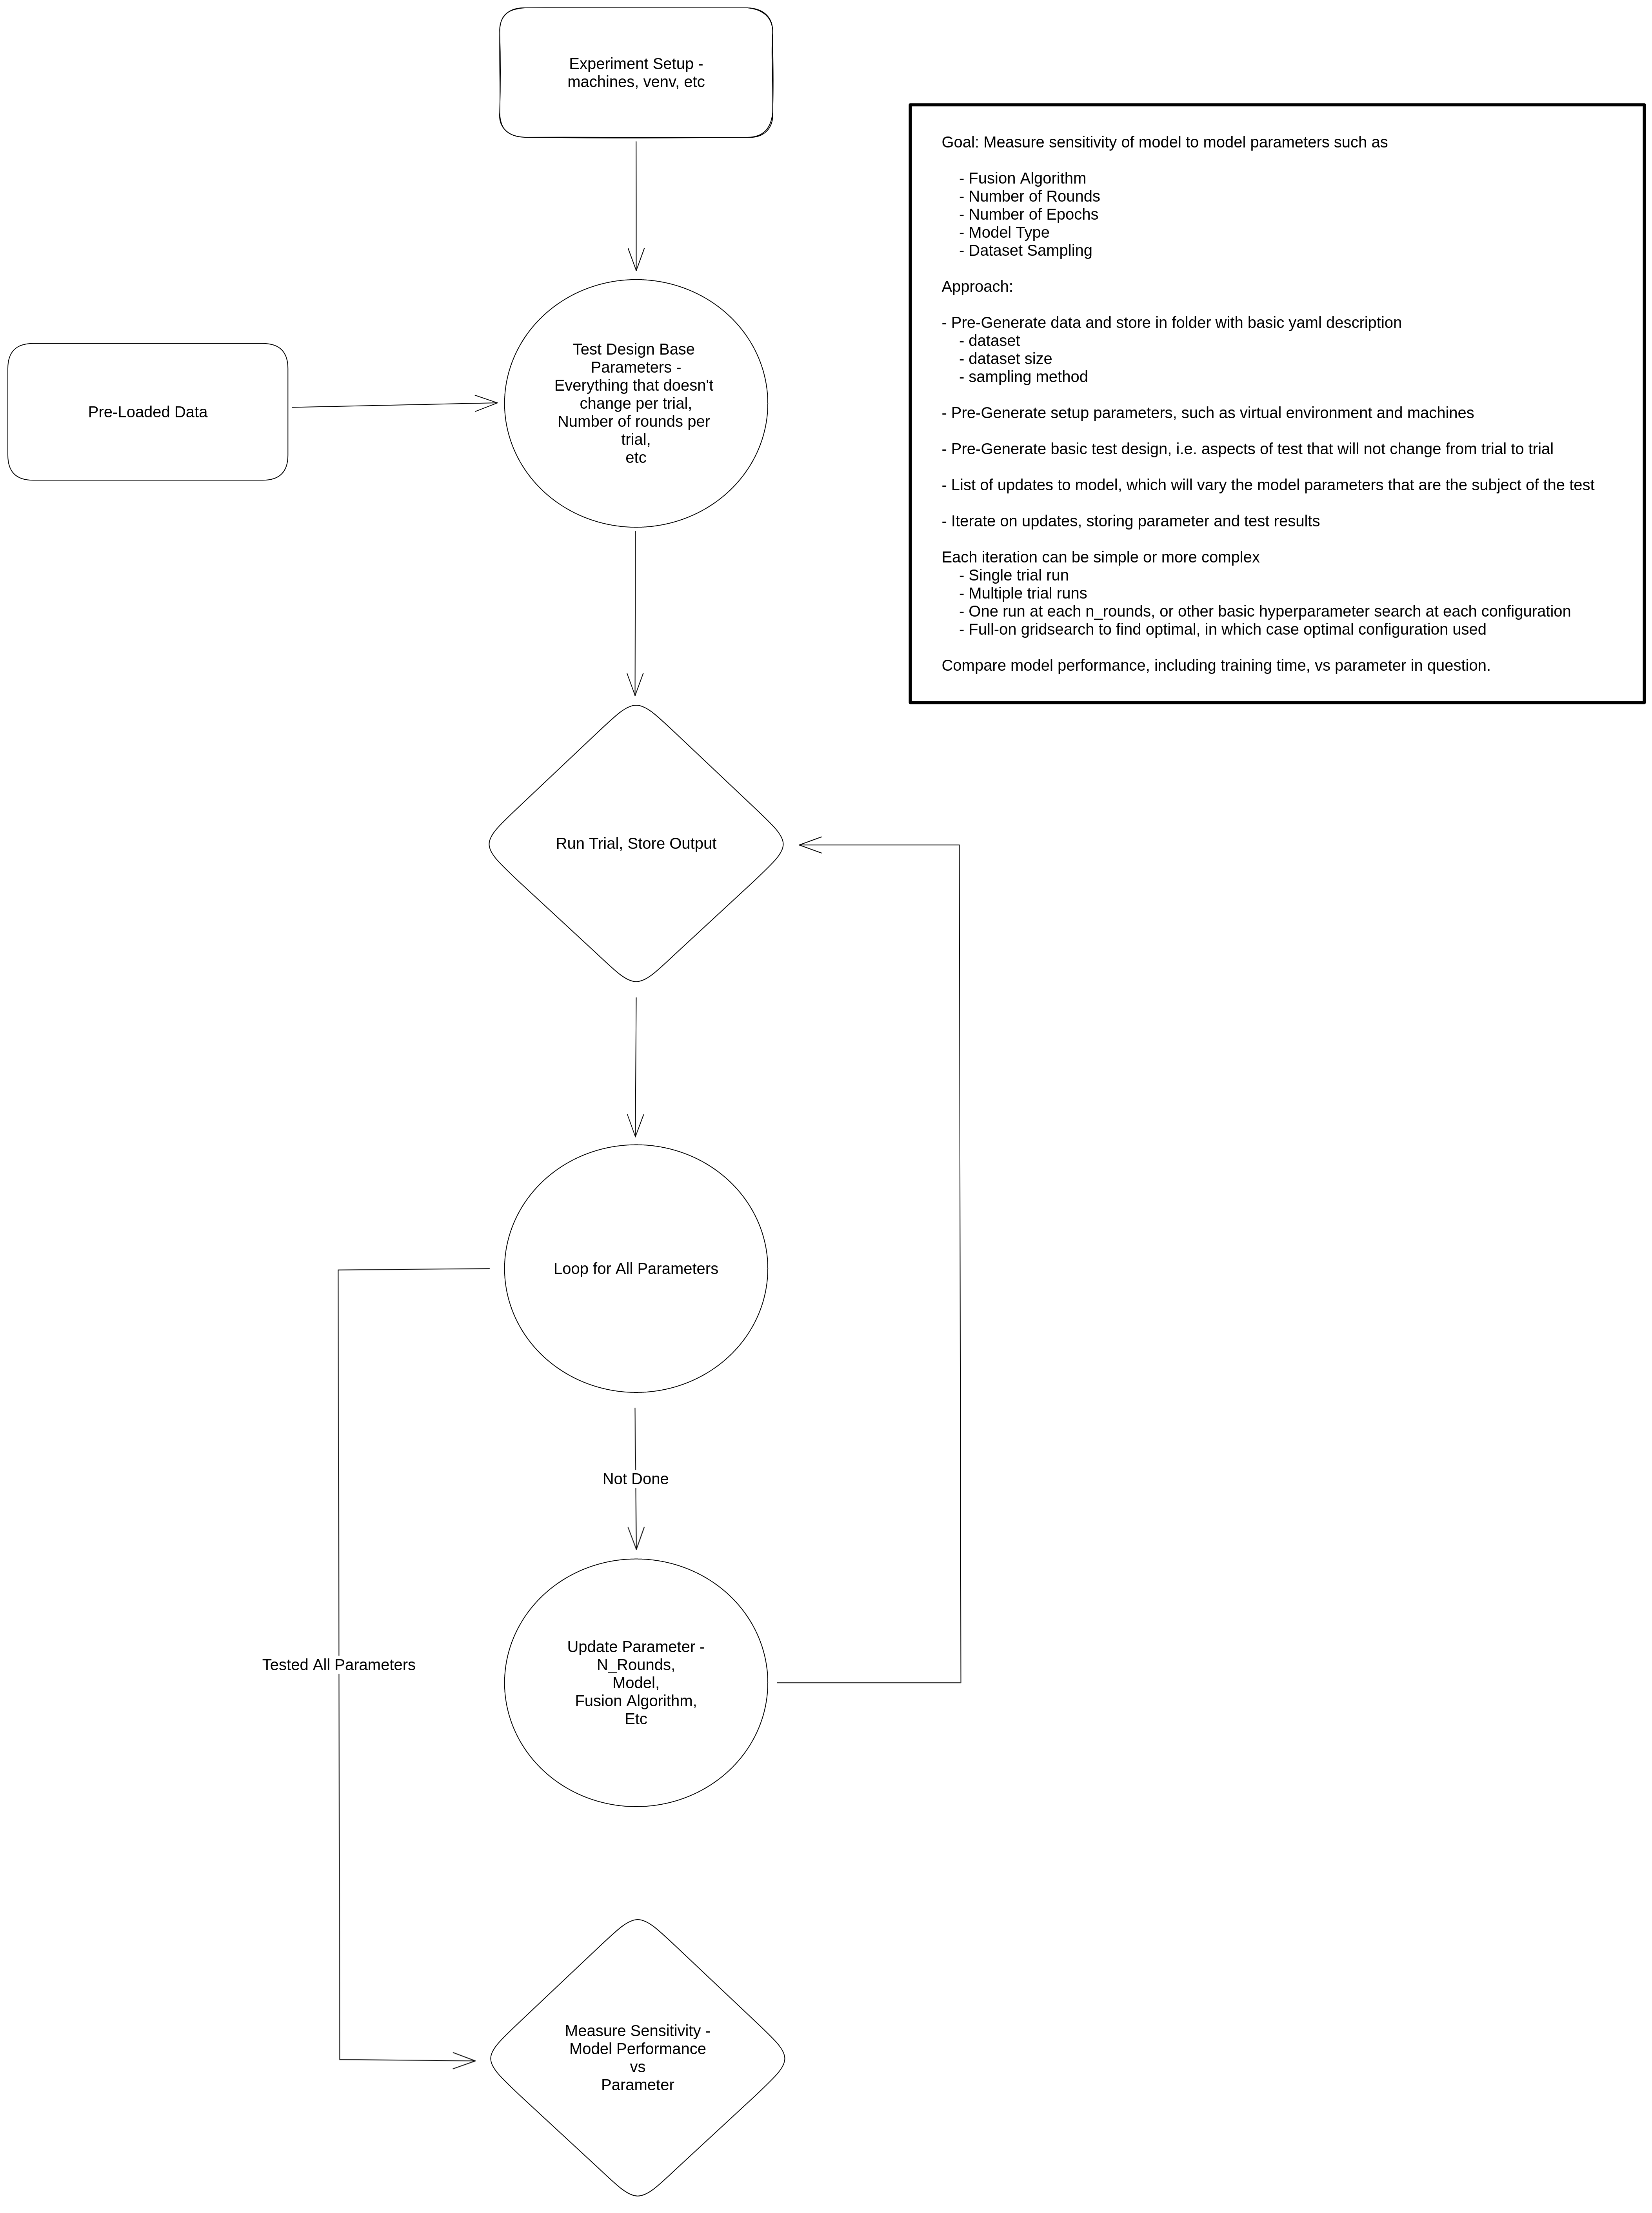